In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf

# Force TensorFlow to use the GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Set the GPU as the default device
#with tf.device('/device:GPU:0'):
    # Your TensorFlow code here
    # Operations within this block will run on the GPU

Found GPU at: /device:GPU:0


In [ ]:
#Reading npy File

import numpy as np

X_file_path = '/content/drive/MyDrive/COVID/X.npy'
y_file_path = '/content/drive/MyDrive/COVID/y.npy'
X = np.load(X_file_path)
y = np.load(y_file_path)

#normalised
height, width, channels = 128, 128, 3
X = X.reshape(-1, height, width, channels)
X_normalized = X.astype('float32') / 255.0
del(X)
X_normalized

array([[[[7.54051059e-02, 7.54051059e-02, 7.54051059e-02],
         [7.58374408e-02, 7.58374408e-02, 7.58374408e-02],
         [7.58272037e-02, 7.58272037e-02, 7.58272037e-02],
         ...,
         [8.45605582e-02, 8.45605582e-02, 8.45605582e-02],
         [8.36703405e-02, 8.36703405e-02, 8.36703405e-02],
         [1.01976104e-01, 1.01976104e-01, 1.01976104e-01]],

        [[8.36397633e-02, 8.36397633e-02, 8.36397633e-02],
         [7.84313753e-02, 7.84313753e-02, 7.84313753e-02],
         [7.84313753e-02, 7.84313753e-02, 7.84313753e-02],
         ...,
         [8.88633579e-02, 8.88633579e-02, 8.88633579e-02],
         [9.02266577e-02, 9.02266577e-02, 9.02266577e-02],
         [1.00668937e-01, 1.00668937e-01, 1.00668937e-01]],

        [[7.97487721e-02, 7.97487721e-02, 7.97487721e-02],
         [8.10202211e-02, 8.10202211e-02, 8.10202211e-02],
         [7.84313753e-02, 7.84313753e-02, 7.84313753e-02],
         ...,
         [8.75306353e-02, 8.75306353e-02, 8.75306353e-02],
         [

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
del(X_normalized)
del(y)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(9665, 128, 128, 3)
(2072, 128, 128, 3)
(2071, 128, 128, 3)


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.models import Sequential

# Load the VGG19 model with pre-trained weights
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the VGG19 model
for layer in base_model.layers:
    layer.trainable = False

# Create custom model on top of VGG19
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation("sigmoid"))

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Set up early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs without improvement before stopping
    restore_best_weights=True  # Restore model weights to the best achieved during training
)

# Train with early stopping
hist = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
303/303 [==============================] - 37s 80ms/step - loss: 0.2532 - accuracy: 0.8982 - val_loss: 0.1446 - val_accuracy: 0.9459
Epoch 2/50
303/303 [==============================] - 20s 65ms/step - loss: 0.1435 - accuracy: 0.9450 - val_loss: 0.8938 - val_accuracy: 0.7761
Epoch 3/50
303/303 [==============================] - 20s 65ms/step - loss: 0.1760 - accuracy: 0.9377 - val_loss: 0.2368 - val_accuracy: 0.9160
Epoch 4/50
303/303 [==============================] - 22s 71ms/step - loss: 0.0952 - accuracy: 0.9649 - val_loss: 0.1720 - val_accuracy: 0.9363
Epoch 5/50
303/303 [==============================] - 22s 72ms/step - loss: 0.0831 - accuracy: 0.9705 - val_loss: 0.1590 - val_accuracy: 0.9421
Epoch 6/50
303/303 [==============================] - 20s 66ms/step - loss: 0.0831 - accuracy: 0.9691 - val_loss: 0.1906 - val_accuracy: 0.9334
Epoch 7/50
303/303 [==============================] - 20s 66ms/step - loss: 0.0772 - accuracy: 0.9707 - val_loss: 0.1138 - val_accuracy:

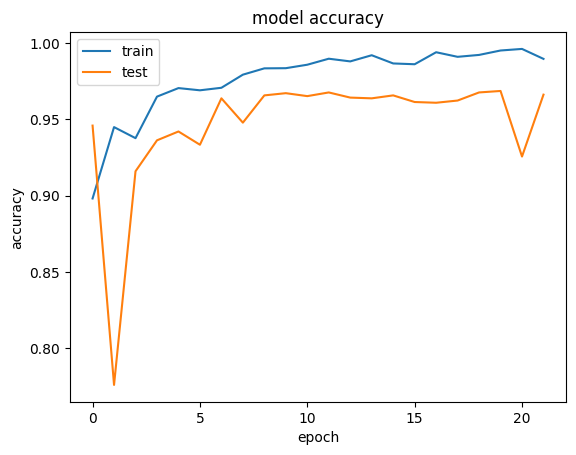

In [ ]:
from matplotlib import pyplot  as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc ='upper left')
plt.show()

In [ ]:
#summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc ='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/COVID/CovidDetector.h5')
model.save('/content/drive/MyDrive/COVID/CovidDetector.keras')

In [ ]:
y_hat = model.predict(X_test)
def predict(y_hat):
    y_hat[y_hat >= 0.5] =1
    y_hat[y_hat<0.5] =0
    return y_hat
y_pred = predict(y_hat)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
result= []
real_result = []
for i in y_pred:
    if i==0:
        result.append('NORMAL')
    if i==1:
        result.append('COVID')
for i in y_pred:
    if i==0:
        real_result.append('NORMAL')
    if i==1:
        real_result.append('COVID')

65/65 [==============================] - 3s 54ms/step
0.9724770642201835


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
labels = ['COVID', 'NORMAL']
report = classification_report(y_test, y_pred, target_names=labels)
print(report)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

       COVID       0.98      0.99      0.98      1551
      NORMAL       0.96      0.93      0.94       520

    accuracy                           0.97      2071
   macro avg       0.97      0.96      0.96      2071
weighted avg       0.97      0.97      0.97      2071

Accuracy: 0.9724770642201835


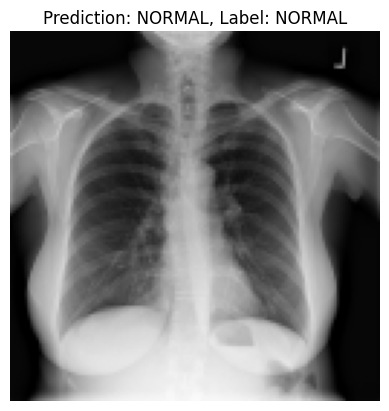

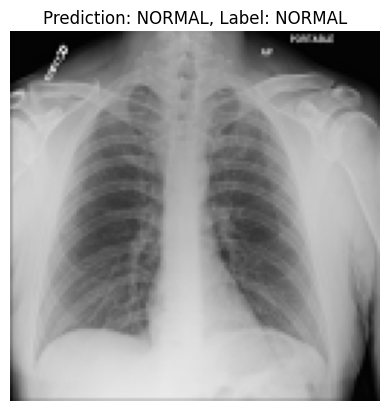

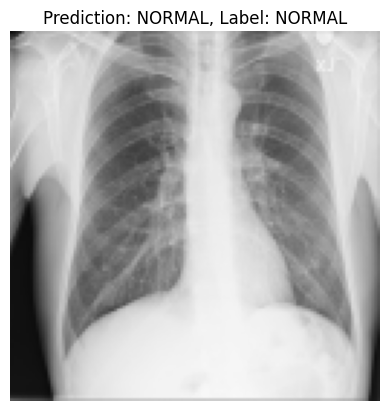

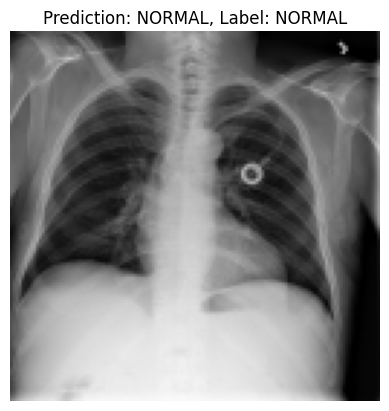

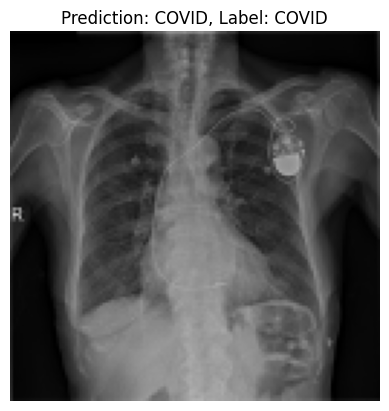

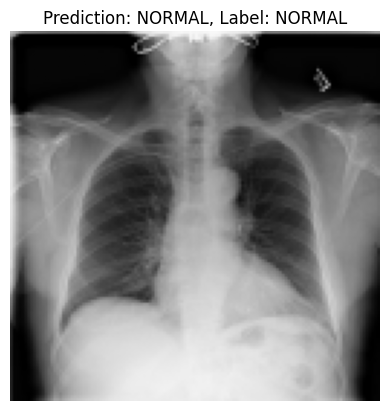

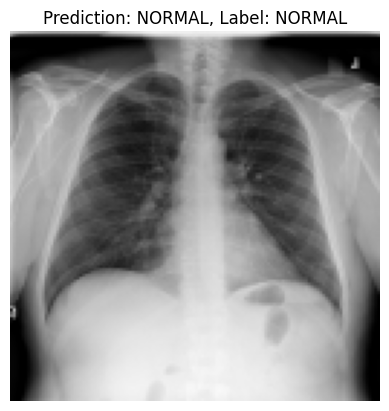

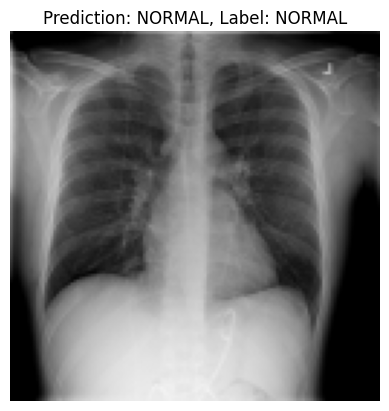

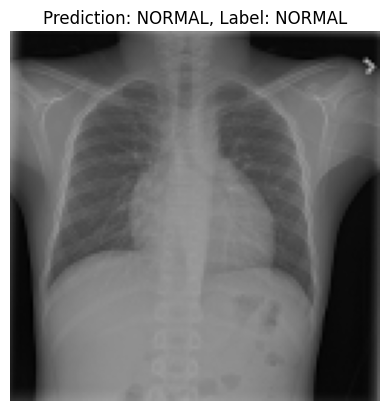

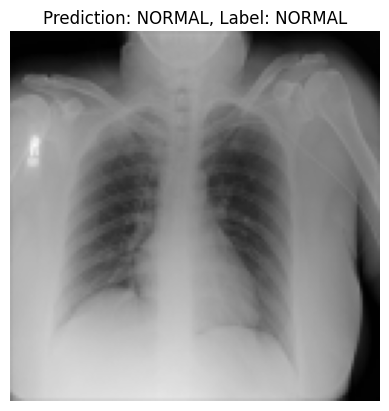

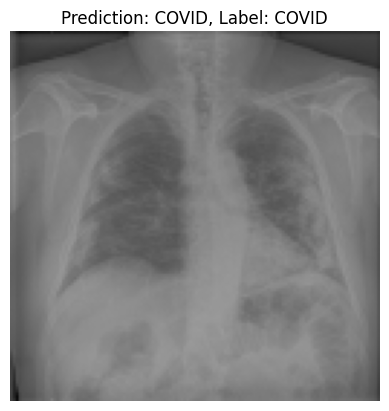

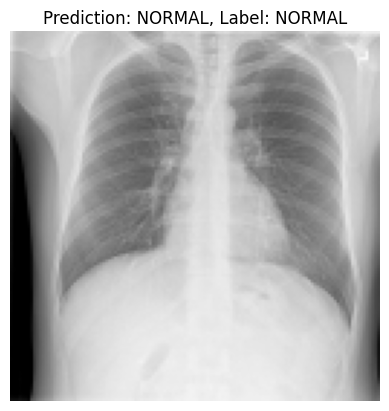

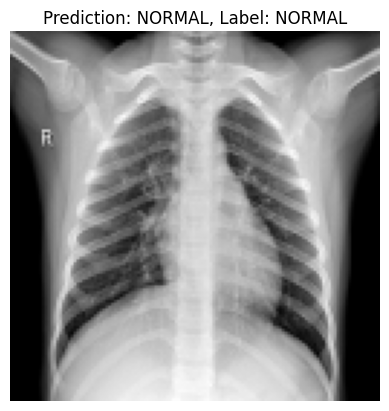

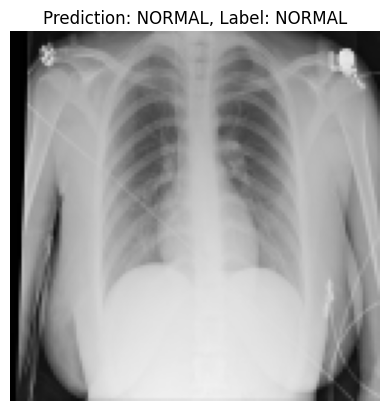

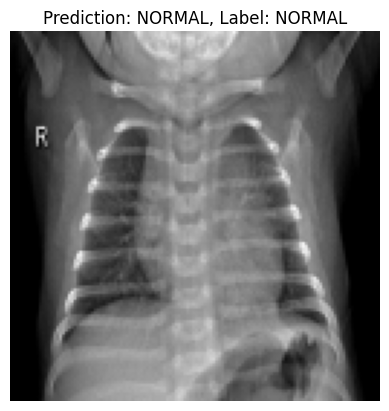

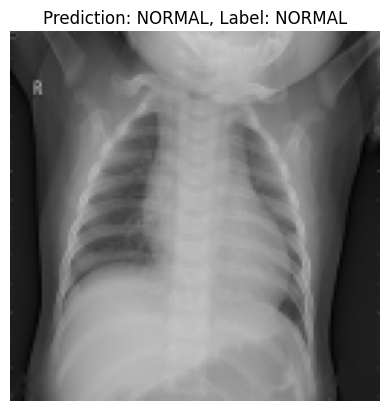

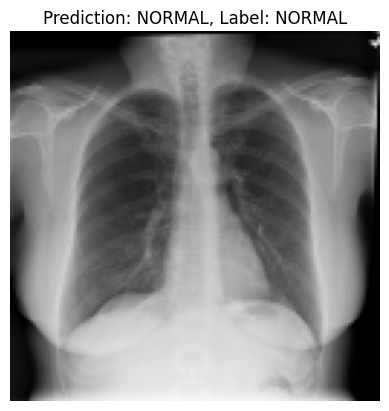

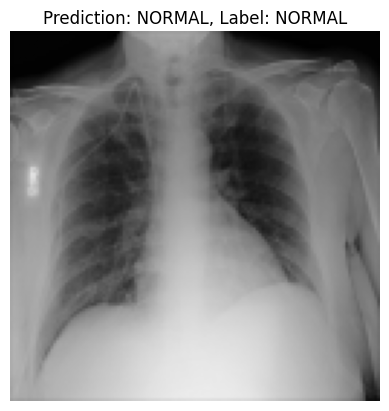

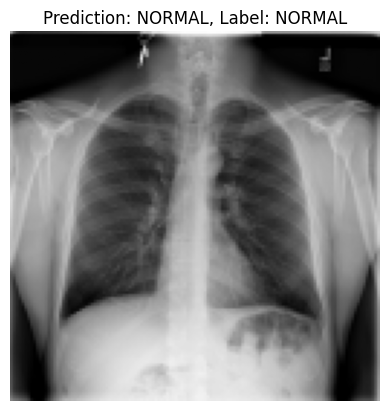

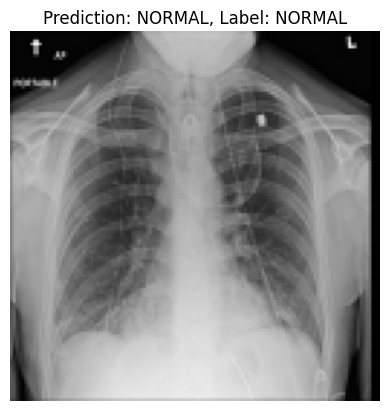

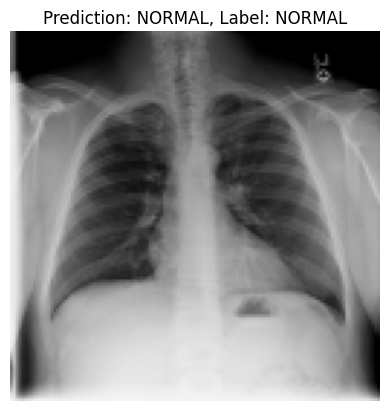

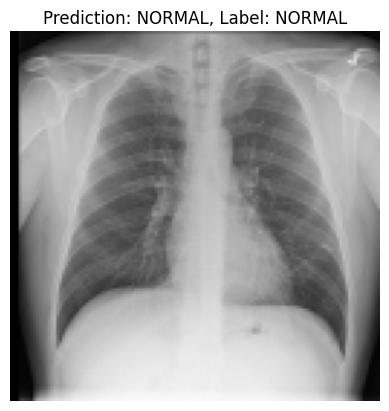

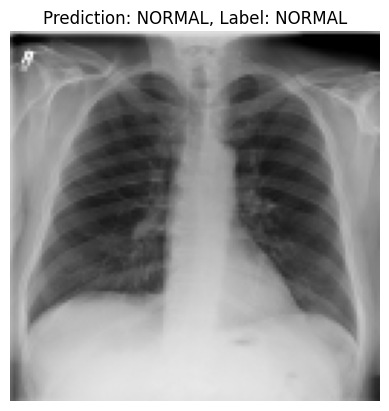

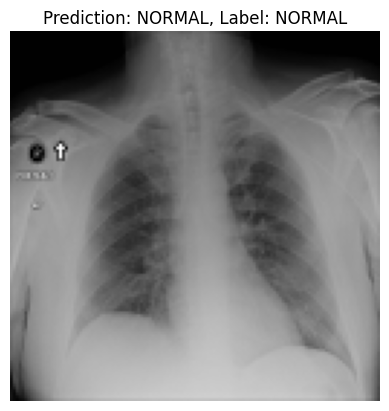

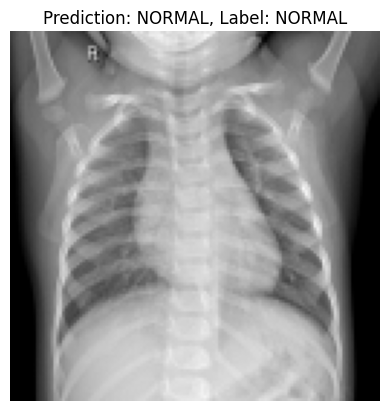

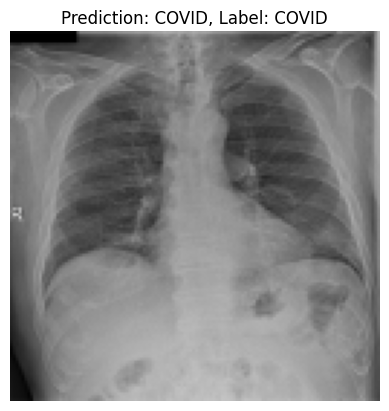

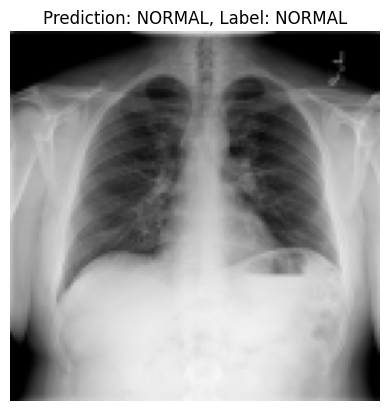

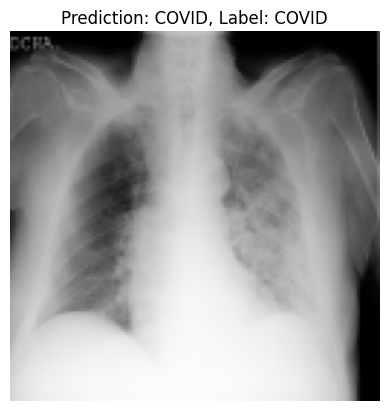

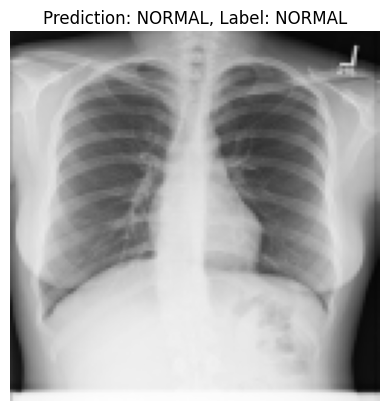

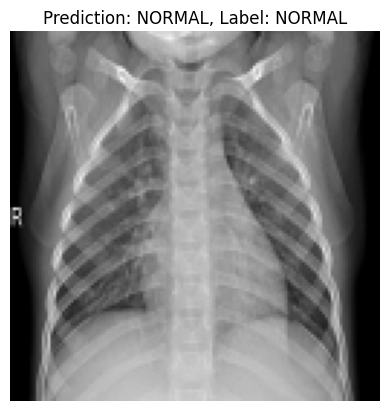

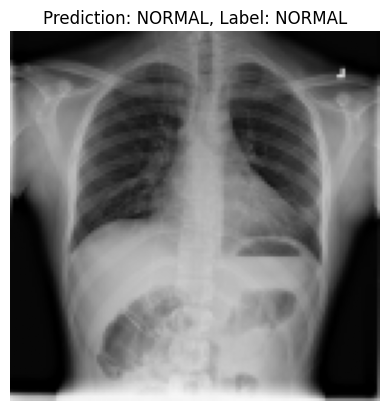

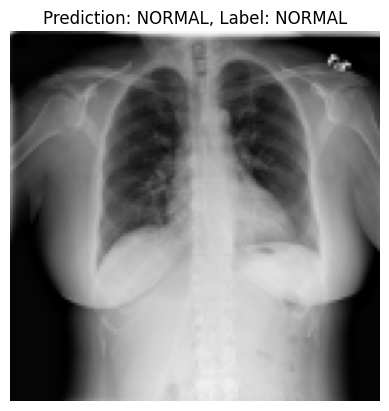

In [ ]:
def show_image_with_prediction(image_array, prediction, label):
    plt.imshow(image_array)
    plt.axis('off')
    plt.title(f'Prediction: {prediction}, Label: {label}')
    plt.show()

image_arrays = X_test
predictions = result
label = real_result

random_indices = np.random.choice(len(X_test), 50, replace=False)
for index in random_indices:
    image_array = X_test[index]
    prediction = result[index]
    true_label = label[index]
    show_image_with_prediction(image_array, prediction, true_label)